In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def reduce_memory_usage(df):
    """Downcasts numeric columns to reduce memory usage."""
    for col in df.select_dtypes(include=['int64','float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# train = reduce_memory_usage(train)
# test = reduce_memory_usage(test)

X = train.drop(['id','rainfall'], axis=1)
y = train['rainfall']

test_ids = test['id']
X_test = test.drop(['id'], axis=1)


## Advanced Feature Engineering

This cell defines a comprehensive `advanced_features` function.  
- It creates a date using only the `day` column by assuming a base date of 2024-01-01.  
- It adds many meaningful features (date-based, periodic, interaction, ratio, and lag features).  
- For training data, it computes lag features based on `rainfall`.  
- For test data (where `rainfall` is not available), it assigns default values (0) for `gap_before_rain` and `gap_after_ain`.


In [8]:
def advanced_features(df, is_train=False, target_series=None):
    """
    Generate advanced features.
    - Assumes df has a 'day' column.
    - Constructs a 'date' from a base date (2024-01-01) plus (day - 1).
    - Adds date-based, periodic, interaction, and ratio features.
    - If is_train=True, and target_series is provided, computes lag features (gap_before_rain, gap_after_rain) based on rainfall.
    - For test data (is_train=False), sets gap features to default (0) so that the same columns exist.
    """
    df = df.copy()
    
    # Build date from 'day': day=1 -> 2024-01-01, day=2 -> 2024-01-02, etc.
    base_date = pd.to_datetime('2024-01-01')
    df['date'] = base_date + pd.to_timedelta(df['day'] - 1, unit='D')
    
    # Date-based features
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['day_of_week'] = df['date'].dt.weekday
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    # Periodic features based on day of year
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Temperature-related features (adjust column names as per your dataset)
    if 'maxtemp' in df.columns and 'mintemp' in df.columns:
        df['temp_range'] = df['maxtemp'] - df['mintemp']
    if 'temparature' in df.columns and 'dewpoint' in df.columns:
        df['temp_dew_diff'] = df['temparature'] - df['dewpoint']
    
    # Ratio features (example from heatmap insights)
    if 'humidity' in df.columns and 'cloud' in df.columns:
        df['humidity_cloud_ratio'] = df['humidity'] / (df['cloud'] + 1e-3)
    if 'sunshine' in df.columns and 'cloud' in df.columns:
        df['sunshine_cloud_ratio'] = df['sunshine'] / (df['cloud'] + 1e-3)
    if 'pressure' in df.columns and 'winddirection' in df.columns:
        df['pressure_wind_interaction'] = df['pressure'] * df['winddirection']
    if 'temparature' in df.columns and 'pressure' in df.columns:
        df['temp_pressure_ratio'] = df['temparature'] / (df['pressure'] + 1e-3)
    if 'windspeed' in df.columns and 'pressure' in df.columns:
        df['wind_pressure_ratio'] = df['windspeed'] / (df['pressure'] + 1e-3)
    
    # Gap features based on rainfall
    if is_train:
        if target_series is not None:
            df['rainfall'] = target_series.values
        df = df.sort_values('date').reset_index(drop=True)
        df['rain_prev_day'] = df['rainfall'].shift(1).fillna(0)
        df['rain_next_day'] = df['rainfall'].shift(-1).fillna(0)
        df['gap_before_rain'] = df.groupby((df['rain_prev_day'] != df['rainfall']).cumsum()).cumcount()
        df['gap_after_rain'] = df[::-1].groupby((df['rain_next_day'] != df['rainfall']).cumsum()).cumcount()
        df.drop(['rain_prev_day', 'rain_next_day'], axis=1, inplace=True)
    else:
        # For test data, we don't have rainfall, so we fill with 0 (or another default value)
        df['gap_before_rain'] = 0
        df['gap_after_rain'] = 0
    
    # Drop the date column (to avoid leakage)
    df.drop(['date'], axis=1, inplace=True, errors='ignore')
    
    return df

# Apply advanced features
X_fe = advanced_features(pd.concat([X, y], axis=1), is_train=True, target_series=y)
y_fe = X_fe.pop('rainfall')
X_test_fe = advanced_features(X_test, is_train=False)

print("Enhanced Train Shape:", X_fe.shape)
print("Enhanced Test Shape:", X_test_fe.shape)

Enhanced Train Shape: (2190, 27)
Enhanced Test Shape: (730, 27)


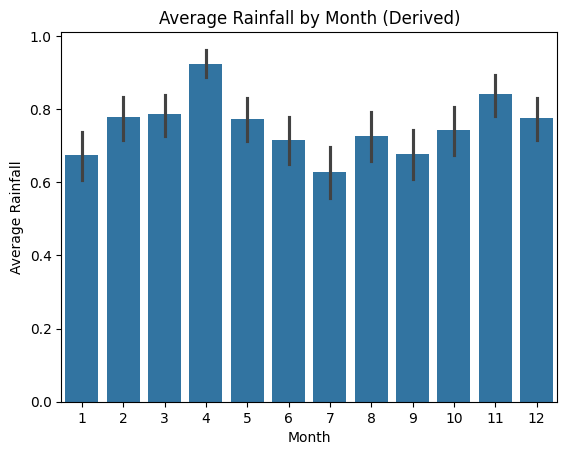

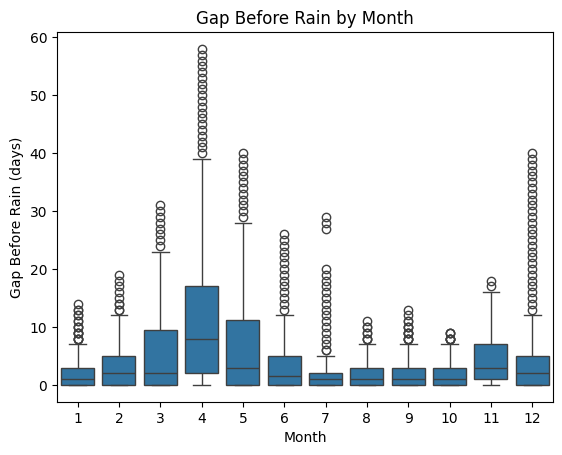

In [9]:
# Create a month column from day_of_year for visualization purposes
X_fe['month'] = ((X_fe['day_of_year']-1) // 30 + 1).clip(upper=12)
sns.barplot(x='month', y=y_fe, data=X_fe)
plt.title("Average Rainfall by Month (Derived)")
plt.xlabel("Month")
plt.ylabel("Average Rainfall")
plt.show()

# Visualize one more relationship: e.g., gap_before_rain vs rainfall
sns.boxplot(x='month', y='gap_before_rain', data=X_fe)
plt.title("Gap Before Rain by Month")
plt.xlabel("Month")
plt.ylabel("Gap Before Rain (days)")
plt.show()

In [10]:
def treat_outliers_iqr(df):
    df = df.copy()
    for col in df.select_dtypes(include=['float','int']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower, upper)
    return df

X_fe_iqr = treat_outliers_iqr(X_fe)
X_test_fe_iqr = treat_outliers_iqr(X_test_fe)

In [11]:
def train_and_submit(X_train, y_train, X_pred, model, param_dist, model_name, scaler_choice='standard'):
    """
    Trains a model using a pipeline that includes imputation and scaling.
    Performs hyperparameter tuning using RandomizedSearchCV.
    Saves submission CSV named model_name_submission.csv.
    Returns the best CV AUC score.
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = RandomizedSearchCV(pipeline, param_dist, n_iter=30, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    best_score = search.best_score_
    print(f"Best CV ROC AUC for {model_name}: {best_score:.4f}")
    print("Best Params:", search.best_params_)
    
    preds = search.predict_proba(X_pred)[:,1]
    submission = pd.DataFrame({'id': test_ids, 'rainfall': preds})
    submission.to_csv(f"{model_name}_submission.csv", index=False)
    return best_score

In [12]:
# Define parameter grids for each model:
param_grids = {
    'LogisticRegression': {
        'clf__C': np.logspace(-3,2,10),
        'clf__solver': ['lbfgs','liblinear']
    },
    'DecisionTree': {
        'clf__max_depth': [3,5,7,None],
        'clf__min_samples_split': [2,5,10]
    },
    'ExtraTrees': {
        'clf__n_estimators': [50,100,150],
        'clf__max_depth': [5,7,None]
    },
    'RandomForest': {
        'clf__n_estimators': [50,100,150],
        'clf__max_depth': [5,7,None]
    },
    'XGBoost': {
        'clf__n_estimators': [50,100,150],
        'clf__max_depth': [3,5,7]
    },
    'CatBoost': {
        'clf__iterations': [100,200],
        'clf__depth': [4,6]
    },
    'LGBM': {
        'clf__num_leaves': [31,50],
        'clf__n_estimators': [50,100,150]
    },
    'KNN': {
        'clf__n_neighbors': [3,5,7],
        'clf__weights': ['uniform','distance']
    },
    'SVC': {
        'clf__C': [0.1,1,10],
        'clf__kernel': ['linear','rbf']
    }
}

# Models dictionary
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42)
}

# We'll store results in a list
model_results = {}

# Run models on the dataset AFTER IQR treatment and with Standard Scaling.
for model_name, model in models.items():
    print(f"\nTraining {model_name} on IQR-treated & Standard Scaled features:")
    auc = train_and_submit(X_fe_iqr, y_fe, X_test_fe_iqr, model, param_grids[model_name], model_name)
    model_results[model_name] = auc


Training LogisticRegression on IQR-treated & Standard Scaled features:
Best CV ROC AUC for LogisticRegression: 0.9372
Best Params: {'clf__solver': 'lbfgs', 'clf__C': 0.5994842503189409}


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- month


In [ ]:
# Define expanded DNN model function (from previous cell)
def create_expanded_dnn_model(optimizer='adam', dropout_rate=0.3, learning_rate=0.001,
                              num_layers=3, units1=64, units2=32, units3=16):
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(X_fe_iqr.shape[1],)))
    model.add(Dropout(dropout_rate))
    if num_layers >= 2:
        model.add(Dense(units2, activation='relu'))
        model.add(Dropout(dropout_rate))
    if num_layers >= 3:
        model.add(Dense(units3, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
    return model

# Wrap the expanded DNN model
dnn_wrapper = KerasClassifier(
    model=create_expanded_dnn_model,
    epochs=20,
    batch_size=32,
    verbose=0
)

# Expanded hyperparameter grid for DNN
dnn_param_grid = {
    'dnn__model__optimizer': ['adam', 'rmsprop'],
    'dnn__model__dropout_rate': [0.2, 0.3, 0.4],
    'dnn__model__learning_rate': [1e-3, 1e-4, 5e-4],
    'dnn__epochs': [20, 30, 50],
    'dnn__batch_size': [16, 32, 64],
    'dnn__model__num_layers': [2, 3, 4],
    'dnn__model__units1': [32, 64, 128],
    'dnn__model__units2': [32, 64, 128],
    'dnn__model__units3': [16, 32, 64]
}

# Build a pipeline for the DNN
dnn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('dnn', dnn_wrapper)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_dnn = RandomizedSearchCV(dnn_pipeline, dnn_param_grid, n_iter=100, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
search_dnn.fit(X_fe_iqr, y_fe)

print(f"Best DNN AUC: {search_dnn.best_score_:.4f}")
print("Best DNN Params:", search_dnn.best_params_)

# Predict using the best DNN and save submission
dnn_preds = search_dnn.predict_proba(X_test_fe_iqr)[:,1]
pd.DataFrame({'id': test_ids, 'rainfall': dnn_preds}).to_csv("DNN_submission.csv", index=False)
model_results['DNN'] = search_dnn.best_score_

In [ ]:
results_df = pd.DataFrame(model_results.items(), columns=['Model', 'AUC']).sort_values(by='AUC', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
plt.title("Model Comparison (After IQR & Standard Scaling)")
plt.xlabel('ROC AUC')
plt.xlim(0.75, 1.0)
plt.show()